In [104]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.keras.backend as K
from tensorflow.keras import datasets, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Concatenate, UpSampling2D, Conv2DTranspose, Dense
from PIL import Image, ImageOps
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from datetime import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import random

# Load the TensorBoard notebook extension
%load_ext tensorboard

# import sys
# sys.path.append("H:\\COMP3710\\PatternFlow\\recognition\\Segment_UNet_s4354061_Elliott_Cutmore")
# from segment import *



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [105]:
def get_img_target_paths(img_dir, seg_dir):
    input_img_paths = sorted(
        [
            os.path.join(img_dir, fname)
            for fname in os.listdir(img_dir)
            if fname.endswith(".jpg")
        ]
    )
    target_img_paths = sorted(
        [
            os.path.join(seg_dir, fname)
            for fname in os.listdir(seg_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
    )
    return input_img_paths, target_img_paths


def get_img_sizes(input_paths):
    sizes = [Image.open(f, 'r').size for f in input_paths]
    return sizes

In [160]:
# black and white segmentation
num_classes = 2
# how many images to run through net:
batch_size = 4
epochs = 1

img_dir = "H:\COMP3710\ISIC2018_Task1-2_Training_Input_x2"
seg_dir = "H:\COMP3710\ISIC2018_Task1_Training_GroundTruth_x2"
save_model_filename = ".\\model_1"
save_path = ".\\training_1\\cp.ckpt"

In [ ]:
input_img_paths, target_img_paths = get_img_target_paths(img_dir, seg_dir)

In [107]:
print(len(input_img_paths))
sizes = get_img_sizes(input_img_paths)
print(type(sizes))
max_w = max(sizes, key=lambda item: item[0])
max_h = max(sizes, key=lambda item: item[1])
min_w = min(sizes, key=lambda item: item[0])
min_h = min(sizes, key=lambda item: item[1])

print("max_h: ", str(max_h), "\nmax_w: ", str(max_w), "\nmin_h: ", str(min_h), "\nmin_w: ", str(min_w))

# max_w_seg, max_h_seg, min_w_seg, min_h_seg = get_img_sizes(target_img_paths)
# print("\nmax_h_seg: ", str(max_h_seg), "\nmax_w_seg: ", str(max_w_seg), "\nmin_h_seg: ", str(min_h_seg), "\nmin_w_seg: ", str(min_w_seg))


2594
<class 'list'>
max_h:  (3374, 2250) 
max_w:  (3374, 2250) 
min_h:  (361, 270) 
min_w:  (288, 384)


[(511, 384), (511, 384), (511, 384), (511, 384), (511, 384), (511, 384), (511, 384), (511, 384), (511, 384), (511, 384)]
(2594,)
(2594,)
100   100


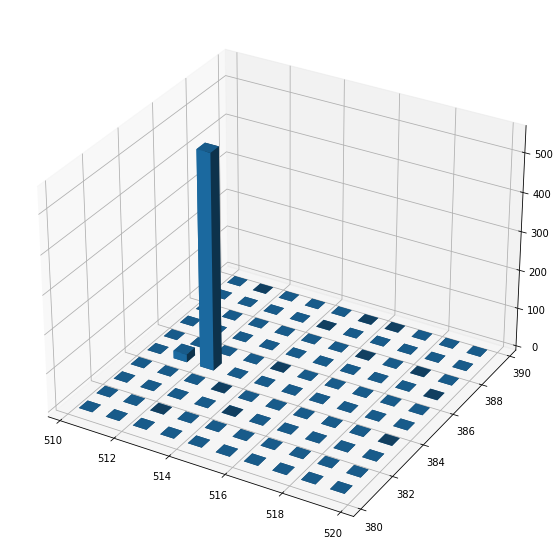

Text(0.5, 1.0, 'histogram height')

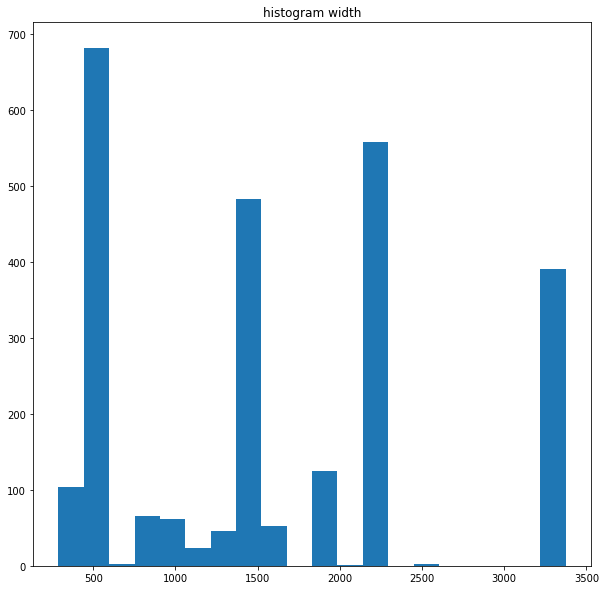

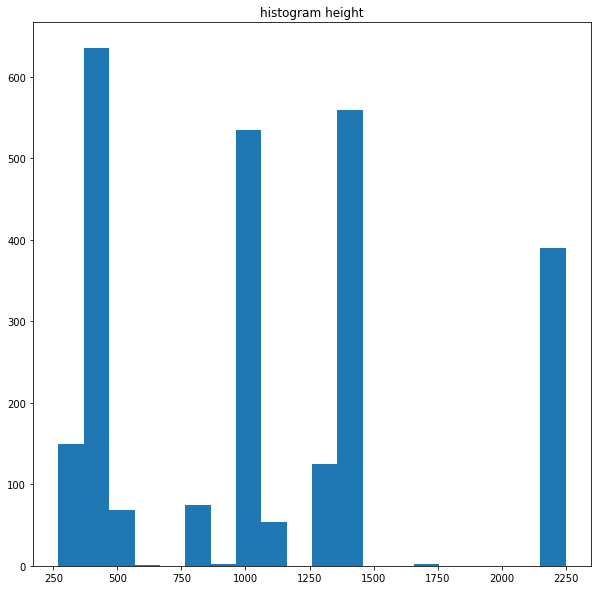

In [108]:
print(sizes[:10])
w = [i[0] for i in sizes]
h = [i[1] for i in sizes]

w = np.array(w)
h = np.array(h)

print(w.shape)
print(h.shape)
# print(len(w))
# print(len(h))
# 
# print(w[:-10])
# print(h[:-10])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x, y = np.random.rand(2, 100) * 4
print(len(x), " ", len(y))
x = np.array(x)
y = np.array(y)
# hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])
hist, xedges, yedges = np.histogram2d(w, h, bins=10, range=[[510, 520], [380, 390]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

bin_size = 20
c = 2;
plt.figure(c, figsize=(10, 10))
plt.hist(w.reshape(len(sizes)), bins=bin_size)
plt.title("histogram width")
c+=1
plt.figure(c, figsize=(10, 10))
plt.hist(h.reshape(len(sizes)) , bins=bin_size)
plt.title("histogram height") 


In [109]:
# img_dims = (384, 512, 3) #h, w
# img_size = (384, 512) #h, w


img_dims = (256, 256, 3) #h, w
img_size = (256, 256) #h, w

In [110]:
def train_test_val_split(val_split, input_img_paths, target_img_paths, test_split=0.05, seed=1337):
    # Split our img paths into a training and a validation set
    test_samples = int(test_split * len(input_img_paths))
    val_samples = int(val_split * (len(input_img_paths) - test_samples))
    train_samples = len(input_img_paths) - test_samples - val_samples
    print("\nTrain: ", str(len(input_img_paths) - test_samples - val_samples),"\nTest: ",  str(test_samples), "\nVal: ", str(val_samples))

    random.Random(seed).shuffle(input_img_paths)
    random.Random(seed).shuffle(target_img_paths)
    train_input_img_paths = input_img_paths[:train_samples]
    train_target_img_paths = target_img_paths[:train_samples]
    val_input_img_paths = input_img_paths[train_samples:(train_samples+val_samples)]
    val_target_img_paths = target_img_paths[train_samples:(train_samples+val_samples)]
    test_input_img_paths = input_img_paths[(train_samples+val_samples):]
    test_target_img_paths = target_img_paths[(train_samples+val_samples):]

    return train_input_img_paths, train_target_img_paths, val_input_img_paths, val_target_img_paths, test_input_img_paths, test_target_img_paths

In [122]:
def create_model(img_dims, num_classes):
    # Free up RAM in case the model definition cells were run multiple times
    # keras.backend.clear_session()

    act = 'relu'
    kern = 'he_uniform'
    pad = 'same'
    inter = 'nearest'
    f = [64, 128, 256, 512, 1024]

    # Input layer
    # input_layer = layers.Input(shape=train[0].shape)
    input_layer = Input(shape=img_dims, name="Input")

    ## Convolutional layers - Feature learning
    # VGG 1:
    conv_1_1 = Conv2D(f[0], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="conv_1_1")(input_layer)
    conv_1_2 = Conv2D(f[0], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="conv_1_2")(conv_1_1)
    pool_1 = MaxPooling2D((2, 2), strides=(2, 2), name="pool_1")(conv_1_2)

    # VGG 2:
    conv_2_1 = Conv2D(f[1], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="conv_2_1")(pool_1)
    conv_2_2 = Conv2D(f[1], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="conv_2_2")(conv_2_1)
    pool_2 = MaxPooling2D((2, 2), strides=(2, 2), name="pool_2")(conv_2_2)

    # VGG 3:
    conv_3_1 = Conv2D(f[2], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="conv_3_1")(pool_2)
    conv_3_2 = Conv2D(f[2], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="conv_3_2")(conv_3_1)
    pool_3 = MaxPooling2D((2, 2), strides=(2, 2), name="pool_3")(conv_3_2)

    # VGG 4:
    conv_4_1 = Conv2D(f[3], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="conv_4_1")(pool_3)
    conv_4_2 = Conv2D(f[3], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="conv_4_2")(conv_4_1)
    pool_4 = MaxPooling2D((2, 2), strides=(2, 2), name="pool_4")(conv_4_2)

    # Bottom VGG:
    bot_1 = Conv2D(f[4], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="bot_1")(pool_4)
    bot_2 = Conv2D(f[4], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="bot_2")(bot_1)

    # CONCAT 4:
    # cat_4_1 = Conv2DTranspose(f[3], (2, 2), strides=(2, 2), name="up_4")(bot_2)
    cat_4_1 = UpSampling2D((2, 2), interpolation=inter, name="up_4")(bot_2)
    cat_4_1 = Conv2D(f[3], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_4_x")(cat_4_1)
    cat_4_2 = Concatenate(axis=3, name="cat_4")([conv_4_2, cat_4_1])
    cat_4_3 = Conv2D(f[3], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_4_1")(cat_4_2)
    cat_4_4 = Conv2D(f[3], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_4_2")(cat_4_3)

    # CONCAT 3:
    # cat_3_1 = Conv2DTranspose(f[2], (2, 2), strides=(2, 2), name="up_3")(cat_4_4)
    cat_3_1 = UpSampling2D((2, 2), interpolation=inter, name="up_3")(cat_4_4)
    cat_3_1 = Conv2D(f[2], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_3_x")(cat_3_1)
    cat_3_2 = Concatenate(axis=3, name="cat_3")([conv_3_2, cat_3_1])
    cat_3_3 = Conv2D(f[2], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_3_1")(cat_3_2)
    cat_3_4 = Conv2D(f[2], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_3_2")(cat_3_3)

    # CONCAT 2:
    # cat_2_1 = Conv2DTranspose(f[1], (2, 2), strides=(2, 2), name="up_2")(cat_3_4)
    cat_2_1 = UpSampling2D((2, 2), interpolation=inter, name="up_2")(cat_3_4)
    cat_2_1 = Conv2D(f[1], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_2_x")(cat_2_1)
    cat_2_2 = Concatenate(axis=3, name="cat_2")([conv_2_2, cat_2_1])
    cat_2_3 = Conv2D(f[1], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_2_1")(cat_2_2)
    cat_2_4 = Conv2D(f[1], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_2_2")(cat_2_3)

    # CONCAT 1:
    # cat_1_1 = Conv2DTranspose(f[0], (2, 2), strides=(2, 2), name="up_1")(cat_2_4)
    cat_1_1 = UpSampling2D((2, 2), interpolation=inter, name="up_1")(cat_2_4)
    cat_1_1 = Conv2D(f[0], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_1_x")(cat_1_1)
    cat_1_2 = Concatenate(axis=3, name="cat_1")([conv_1_2, cat_1_1])
    cat_1_3 = Conv2D(f[0], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_1_1")(cat_1_2)
    cat_1_4 = Conv2D(f[0], (3, 3), activation=act, kernel_initializer=kern, padding=pad, name="cat_1_2")(cat_1_3)

    # Output layer
    output_layer = Conv2D(num_classes, (1, 1), activation="softmax", kernel_initializer=kern, padding=pad,
                          name="Output")(cat_1_4)
    # output_layer = cat_1_4

    # Create model:
    model = Model(inputs=input_layer, outputs=output_layer, name="Model")

    return model

In [123]:
model = create_model(img_dims, num_classes)

train_input, train_target, val_input, val_target, test_input, test_target = train_test_val_split(0.2, input_img_paths, target_img_paths)
print("array lengths:\nTrain: ", str(len(train_input)), "\nTest: ", str(len(test_input)), "\nVal: ", str(len(val_input)))

model.summary()


Train:  1972 
Test:  129 
Val:  493
array lengths:
Train:  1972 
Test:  129 
Val:  493
Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 256, 256, 64) 1792        Input[0][0]                      
__________________________________________________________________________________________________
conv_1_2 (Conv2D)               (None, 256, 256, 64) 36928       conv_1_1[0][0]                   
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 128, 128, 64) 0           conv_1_2[0][0]                   
______

In [124]:
def load_input_image(path, img_dims):
    img = img_to_array(load_img(path, color_mode='rgb'))
    img = tf.multiply(img,  1/255.)
    img = tf.image.resize(img, [img_dims[0], img_dims[1]], preserve_aspect_ratio=True)
    img = tf.image.resize_with_crop_or_pad(img, img_dims[0], img_dims[1])
    
    return img
    
    
def load_segmented_image(path, img_dims):
    img = img_to_array(load_img(path, color_mode="grayscale"))
    img = tf.multiply(img,  1/255)
    img = tf.image.resize(img, [img_dims[0], img_dims[1]], preserve_aspect_ratio=True)
    img = tf.image.resize_with_crop_or_pad(img, img_dims[0], img_dims[1])
    
    return img
    
    
def load_input_images_from_path_list(batch_input_img_paths, img_dims):
    for j, path in enumerate(batch_input_img_paths):
        img = load_input_image(path, img_dims)
        img = tf.reshape(img, [img_dims[0] * img_dims[1] * img_dims[2]])
        img = tf.cast(img, dtype=tf.float32)
        if j == 0:
            x = img
        else:
            x = tf.concat([x, img], axis=0)
    return tf.reshape(x, [len(batch_input_img_paths), img_dims[0], img_dims[1], img_dims[2]])
        
        
def load_target_images_from_path_list(batch_target_img_paths, img_dims, num_classes):
    for j, path in enumerate(batch_target_img_paths):
        img = load_segmented_image(path, img_dims)
        img = tf.reshape(img, [img_dims[0] * img_dims[1]])
        img = tf.keras.utils.to_categorical(img, num_classes)
        img = tf.reshape(img, [img_dims[0] * img_dims[1]*num_classes])
        img = tf.cast(img, tf.uint8)
        if j == 0:
            y = img
        else:
            y = tf.concat([y, img], axis=0)
    return tf.reshape(y, [len(batch_target_img_paths), img_dims[0], img_dims[1], num_classes])

class CustomSequence(Sequence):
    """Helper to iterate over the data (as TensorFlow arrays)."""

    def __init__(self, batch_size, img_dims, input_img_paths, target_img_paths, num_classes):
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.num_classes = num_classes

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: (i + self.batch_size)]
        batch_target_img_paths = self.target_img_paths[i: (i + self.batch_size)]

        x = load_input_images_from_path_list(batch_input_img_paths, img_dims)
        y = load_target_images_from_path_list(batch_target_img_paths, img_dims, num_classes)        

        return x, y

            

In [125]:
def create_generator(img_dims, batch_size, img_paths, target_paths, num_classes):
    # Instantiate data Sequences for each split
    return CustomSequence(batch_size, img_dims, img_paths, target_paths, num_classes)

In [126]:
train_gen = create_generator(img_dims, batch_size, train_input, train_target, num_classes)
val_gen = create_generator(img_dims, batch_size, val_input, val_target, num_classes)
test_gen = create_generator(img_dims, batch_size, test_input, test_target, num_classes)

In [162]:
def train_model(train_gen, val_gen, model, epochs=1, save_model_filename=None, save_path=None):
    if save_path:
        checkpoint = ModelCheckpoint(filepath=save_path,
                                     save_weights_only=True,
                                     #                              save_best_model,
                                     verbose=1)
        callbacks = [checkpoint]
    else:
        callbacks = []

    ## Compile the model:
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    # loss=dice_coefficient_loss
    # metrics = ['categorical_crossentropy', 'accuracy']
    metrics = ['accuracy']
    opt = Adam(lr = 1e-5)
    model.compile(loss=loss, optimizer=opt, metrics=metrics)

    # Train the model, doing validation at the end of each epoch.
    history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
    
    if save_model_filename:
        print("saving model to %s" %(save_model_filename))
        model.save(save_model_filename)
    
    return history

tf.Tensor([  4 256 256   3], shape=(4,), dtype=int32)
tf.Tensor([  4 256 256   2], shape=(4,), dtype=int32)
tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([1 0], shape=(2,), dtype=uint8)


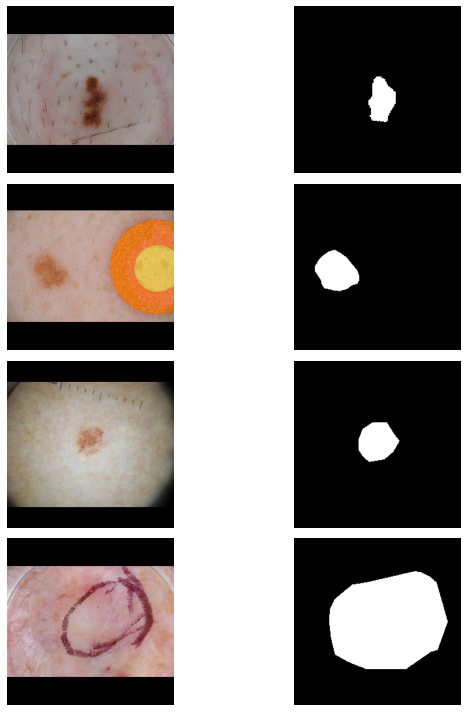

In [163]:
x, y = train_gen.__getitem__(0)
# print(train_input[0], "size: ", Image.open(train_input[0], 'r').size)
# print(train_target[0], "size: ", Image.open(train_target[0], 'r').size)
print(tf.shape(x))
print(tf.shape(y))

xn = np.array(x)
yn = np.array(y)
yn = np.argmax(yn, axis=3)

print(x[0, 250, 250, :])
print(y[0, 250, 250, :])


num_imgs = 4
plt.figure(figsize=(10, 10))
j=1
for i in range(num_imgs):
    ax = plt.subplot(num_imgs, 2, j)
    plt.imshow(xn[i])  # [:, :, 0], cmap='gray') #
    plt.axis("off")
    j = j+1
    ax = plt.subplot(num_imgs, 2, j)
    plt.imshow(yn[i], cmap='gray')  # [:, :, 0], cmap='gray') #
    plt.axis("off")
    j = j+1
plt.tight_layout()
plt.show()

In [164]:
print("save_path: %s" % (save_path))
print("save_model_filename: %s" % (save_model_filename))

history = train_model(train_gen, val_gen, model, epochs=epochs, save_model_filename=save_model_filename, save_path=save_path)

save_path: .\training_1\cp.ckpt
save_model_filename: .\model_1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 493 steps, validate for 123 steps
492/493 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9963
Epoch 00001: saving model to .\training_1\cp.ckpt
493/493 [==============================] - 315s 639ms/step - loss: 0.0087 - accuracy: 0.9963 - val_loss: 0.2176 - val_accuracy: 0.9667
saving model to .\model_1
INFO:tensorflow:Assets written to: .\model_1\assets


In [ ]:
# if save_path:
#     print("saving model to %s" %(save_path))
#     model.save(save_path)

In [154]:
## Load model
load_path = save_path
if load_path:
    print("loading model from %s" %(save_path))
    loaded_model = load_model(load_path)

loading model from .\training_2\cp.ckpt


In [155]:
def dice_coefficient(y_true, y_pred, smooth=0.):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth).numpy()

def dice_coefficient_numpy(y_true, y_pred, smooth=0.):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    gt = y_true.numpy()
    seg = y_pred.numpy()
    
    return np.sum(seg[gt==1])*2.0 / (np.sum(seg) + np.sum(gt))

def load_model(load_path):
    return tf.keras.models.load_model(load_path)


SyntaxError: invalid syntax (<ipython-input-155-1fd303a1df17>, line 18)

In [ ]:
## Plotting
def training_plot(history, epochs):
    ## ACCURACY
    plt.figure(1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.plot([0, epochs], [0.9, 0.9], 'r', linewidth=0.2)
    plt.gca().annotate("95%", xy=(0, 0.95), xytext=(0, 0.95))
    y_max = max(history.history["val_accuracy"])
    x_max = history.history["val_accuracy"].index(y_max)
    plt.gca().annotate(str(round(y_max, 5)), xy=(x_max, y_max), xytext=(x_max, y_max))
    plt.title("Part 3 - Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.9, 1])
    plt.legend(loc='lower right')
    plt.show()

    ## LOSS
    plt.figure(2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    # plt.plot([0, epochs], [0.8, 0.8], 'r', linewidth=0.2)
    # plt.gca().annotate("80%", xy=(epochs, 0.8), xytext=(epochs, 0.8))
    y_max = min(history.history["val_loss"])
    x_max = history.history["val_loss"].index(y_max)
    plt.gca().annotate(str(round(y_max, 5)), xy=(x_max, y_max), xytext=(x_max, y_max))
    plt.title("Part 3 - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def evaluate(test_gen, model):
    test_loss, test_acc = model.evaluate(test_gen)
    test_preds = model.predict(test_gen)
    return test_preds, test_loss, test_acc

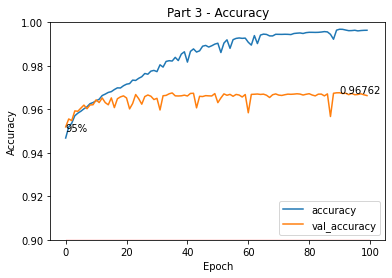

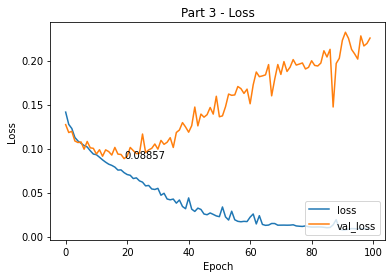

  ...
    to  
  ['...']
32/32 [==============================] - 32s 1s/step - loss: 0.1905 - accuracy: 0.9716
Test set size:  129
Test loss:  0.19045034877490252
Test accuracy:  0.9716146 



In [156]:
training_plot(history, epochs)
test_preds, test_loss, test_acc = evaluate(test_gen, loaded_model)
print("Test set size: ", len(test_input))
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc, '\n')

In [157]:
def results(test_input, test_target, test_preds, num_imgs, img_dims, num_classes):
    num_imgs = 5
    test_input_set = test_input[0:num_imgs]
    test_target_set = test_target[0:num_imgs]
    x = load_input_images_from_path_list(test_input_set, img_dims)
    y = load_target_images_from_path_list(test_target_set, img_dims, num_classes)


    # num_imgs = tf.shape(x).numpy()[0]
    xn = np.array(x)
    yn = np.array(y)
    tn = np.array(test_preds)

    yn = np.argmax(yn, axis=3)
    output = np.argmax(tn, axis=3)
    dice_sim = []

    plt.figure(figsize=(10, 10))
    j=1
    for i in range(num_imgs):
        sim = dice_coefficient(y[i], test_preds[i])
        dice_sim.append(sim)
        sim2 = dice_coefficient_numpy(y[i], test_preds[i])
        print("sim1: %2.4f,\tsim2: %2.4f" % (sim, sim2))
        ax = plt.subplot(num_imgs, 3, j)
        plt.imshow(xn[i])  # [:, :, 0], cmap='gray') #
        plt.axis("off")
        j = j+1
        ax = plt.subplot(num_imgs, 3, j)
        plt.imshow(yn[i], cmap='gray')  # [:, :, 0], cmap='gray') #
        plt.axis("off")
        j = j+1
        ax = plt.subplot(num_imgs, 3, j)
        plt.imshow(output[i], cmap='gray')  # [:, :, 0], cmap='gray') #
        plt.axis("off")
        j = j+1
    plt.tight_layout()
    plt.show()

sim1: 0.9970,	sim2: 0.9970
sim1: 0.9575,	sim2: 0.9575
sim1: 0.9866,	sim2: 0.9866
sim1: 0.9988,	sim2: 0.9988
sim1: 0.9936,	sim2: 0.9936


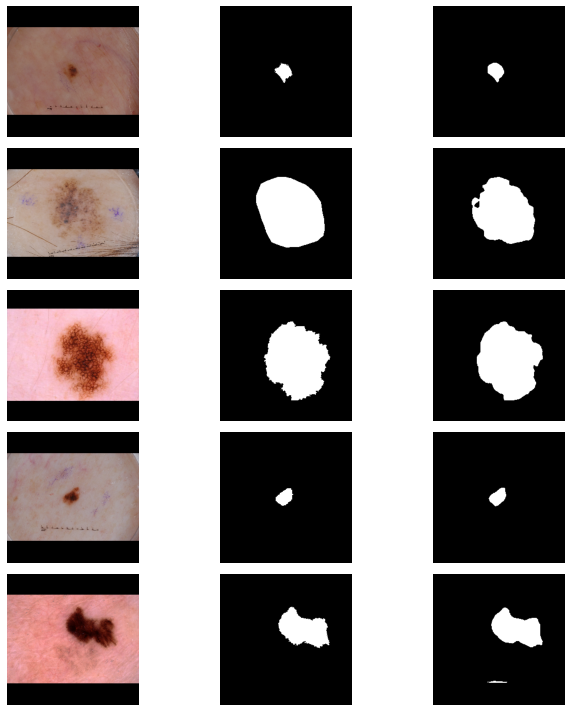

In [158]:
results(test_input, test_target, test_preds, 5, img_dims, num_classes)